In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
%matplotlib inline

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2014,11,1)
end_date = datetime.date(2021,2,18)

sim_products = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', \
                'rb', 'hc', 'i', 'j', 'jm', 'ru', 'ZC', 'FG',\
                'l', 'pp', 'v', 'TA', 'MA',\
                'm', 'RM', 'y', 'p', 'OI', 'a'\
                ] # 
need_shift = 1
freq = 'm'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
ni_args = {'n': 1, 'roll_rule': '-40b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['ni']:
        use_args = ni_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    df = df.reset_index().set_index(['date', 'min_id'])
    if (idx == 0) and (freq == 'm'):
        #df_list.append(df[['date', 'min_id']])
        df_list.append(df[['datetime']])
    xdf = df[field_list]
    xdf.columns = [(asset, col) for col in xdf.columns]
    #print(len(xdf), xdf)
    df_list.append(xdf)

all_df = pd.concat(df_list, axis = 1, sort = False)
all_df = all_df.reset_index()
print(all_df)

loading mkt = cu, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2014, 11, 1), 'end_date': datetime.date(2021, 2, 18)}
loading mkt = al, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2014, 11, 1), 'end_date': datetime.date(2021, 2, 18)}
loading mkt = zn, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2014, 11, 1), 'end_date': datetime.date(2021, 2, 18)}
loading mkt = pb, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2014, 11, 1), 'end_date': datetime.date(2021, 2, 18)}
loading mkt = ni, args = {'n': 1, 'roll_rule': '-40b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 6, 1), 'end_date': datetime.date(2021, 2, 18)}
loading mkt = sn, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 6, 1), 'end_date': datetime.date(2021, 2, 18)}


In [5]:
def run_bktest(input_args):
    product_list = input_args['product_list']
    bar_freq = input_args['bar_freq']
    win_list = [input_args['win']]
    ma_win = input_args['ma_win']
    std_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.0)
    quantile_cutoff = input_args.get('quantile', 0.2)
    prefix = input_args.get('prefix', "")
    run_name = '_'.join(['-'.join(product_list), bar_freq, str(win_list[0]), \
                         str(ma_win), str(rebal_freq), str(pos_std)])
    prod_fields = ['date', 'min_id', 'datetime'] + [(asset, field) for field in field_list for asset in product_list]
    
    xdf = all_df[prod_fields].dropna().sort_values(by=['date', 'min_id']).copy()
    if 's' in bar_freq:
        xdf = dh.day_split1(xdf, split_dict[bar_freq], index_col = None)
    else:
        xdf = dh.conv_ohlc_freq1(xdf, bar_freq, index_col = None) 
    #xdf = df.copy()
    #xdf = dh.day_split1(xdf, [300, 352, 450, 1500, 1528, 1630, 1655, 1724, 1930, 1949, 2018, 2047, 2100])

    #xdf = dh.day_split1(xdf, [300, 1500, 1930, 2115])
    xdf['start_min'] = xdf['datetime'].apply(lambda x: misc.get_min_id(x))

    for asset in product_list:
        if need_shift == 1:
            xdf[(asset, 'lr')] = ((xdf[(asset, 'close')]- xdf[(asset, 'shift')]).astype('float')\
                                    /(xdf[(asset, 'close')].shift(1) - xdf[(asset, 'shift')]) - 1.0) * 100.0
        else:
            xdf[(asset, 'lr')] = (xdf[(asset, 'close')].astype('float')\
                                  / xdf[(asset, 'close')].shift(1) - 1.0) * 100.0
        for ix, win in enumerate(win_list):
            xdf[(asset, 'lr%s' % (ix))] = xdf[(asset, 'lr')].rolling(win).sum().rolling(ma_win).mean()
        if need_shift == 1:
            orig_close = xdf[(asset, 'close')] - xdf[(asset, 'shift')]
        elif need_shift == 2:
            orig_close = xdf[(asset, 'close')] * np.exp(-xdf[(asset, 'shift')])
        else:
            orig_close = xdf[(asset, 'close')]
        if pos_std == 0:
            xdf[(asset, 'std')] = orig_close
        elif pos_std == 1:
            xdf[(asset, 'std')] = xdf[(asset, 'lr')].rolling(std_win).std() * orig_close * 10.0
        elif pos_std == 2:
            xdf[(asset, 'std')] = xdf[(asset, 'close')].diff().rolling(std_win).std() * 10.0
    #xdf[[(asset, 'open') for asset in product_list]].to_csv('data_dump_.csv')
    adf_dict = {}
    rank_dict = {}
    rng_dict = {}
    for col in ['lr%s' % (idx) for idx in range(len(win_list))]:
        adf_dict[col] = xdf[[(asset, col) for asset in product_list]]
        rank_dict[col] = adf_dict[col].rank(axis=1)
        rng_dict[col] = adf_dict[col].max(axis=1) - adf_dict[col].min(axis=1)
    #xdf[[(asset, 'lr') for asset in product_list]].plot()

    total_risk = 100000000.0
    margin_rate = [0.08, 0.08]
    
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [x * cost_ratio for x in offset_list]
    start_capital = 0.0

    kcut = int(quantile_cutoff * len(product_list) + 0.5)
    upper_rank = len(product_list) - kcut
    lower_rank = 1 + kcut
    xdf['rebal_flag'] = 1
    #print rng_dict['lr0'][-10:]
    flag = (xdf['start_min'].isin([])) | (rng_dict['lr0'] < 0.0)
    xdf.loc[flag, 'rebal_flag'] = 0

    xdf['rebal_seqno'] = xdf['rebal_flag'].cumsum()
    #print(xdf[['rebal_seqno', 'start_min', 'rebal_flag']][-10:])

    #xdf['rebal_seqno'] = range(len(xdf.index))

    sum_rank = pd.DataFrame(columns=product_list, index = xdf.index)
    for asset in product_list:
        sum_rank[asset] = rank_dict['lr0'][(asset, 'lr0')]
        for col in ['lr%s'%(idx+1) for idx in range(len(win_list)-1)]:
            sum_rank[asset] = sum_rank[asset] + rank_dict[col][(asset, col)]

    sum_rank = sum_rank.rank(axis=1, method='first')
    long_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)
    short_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx) & (xdf['rebal_flag'] == 1)
        for asset in product_list:
            long_tmp.loc[(sum_rank[asset] > upper_rank) & rebal_flag, asset] = 1.0
            long_tmp.loc[(sum_rank[asset] <= upper_rank) & rebal_flag, asset] = 0.0
            short_tmp.loc[(sum_rank[asset] < lower_rank) & rebal_flag, asset] = 1.0
            short_tmp.loc[(sum_rank[asset] >= lower_rank) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        #long_sum = long_tmp.sum(axis=1)
        #short_sum = short_tmp.sum(axis=1)
        long_pos = long_pos + long_tmp #.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp #.div(short_sum,axis=0)

    net_pos = long_pos - short_pos

    pos_nchg = (net_pos == net_pos.shift(1))
    net_pos[pos_nchg] = np.nan

    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(product_list, offset_list):
        #long_pos[asset] = (long_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
        #short_pos[asset] = (short_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
        net_pos[asset] = (net_pos[asset] * total_risk / (rebal_freq * xdf[(asset, 'std')])).astype('float').shift(1).fillna(method='ffill').fillna(0.0).astype('int')
        #long_pos[asset] = (long_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
        #short_pos[asset] = (short_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
        xdf[(asset, 'pos')] = net_pos[asset]
        #xdf[(asset, 'pos')] = long_pos[asset] - short_pos[asset]
        xdf[(asset, 'traded_price')] = xdf[(asset, 'open')]
        xdf[(asset, 'pos')][-1] = 0
        xdf[(asset, 'cost')] = abs(xdf[(asset, 'pos')] - xdf[(asset, 'pos')].shift(1)) * offset
        xdf[(asset, 'cost')] = xdf[(asset, 'cost')].fillna(0.0)
        fields = [(asset, field) for field in extract_fields]    
        tdf = xdf[fields]
        tdf.columns = extract_fields
        tdf['date'] = xdf['date']
        tdf['min_id'] = xdf['min_id']
        df_list.append(tdf)
        #tdf.to_csv("test_%s_offset_%s.csv" % (asset, offset))
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, 'm', tenors = pnl_tenors, start_capital = start_capital, cost_ratio = 1.0)
    #print(xdf[[(asset, 'pos') for asset in product_list]][-40:])
    xdf[[(asset, 'pos') for asset in product_list]].to_csv(prefix + run_name + '_pos.csv')
    #print(ts['cum_pnl'][-60:])
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df}
    return res


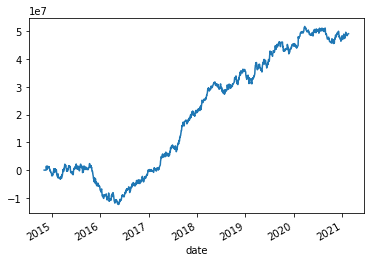

                    rb-hc-i-j_14m_30_12_3_1
avg_pnl_1y                     3.616579e+03
avg_pnl_2y                     3.626913e+04
avg_pnl_3y                     3.430569e+04
avg_pnl_4y                     5.042867e+04
avg_pnl_5y                     4.822918e+04
max_dd_period_1y              -2.190000e+02
max_dd_period_2y              -2.190000e+02
max_dd_period_3y              -2.190000e+02
max_dd_period_4y              -2.190000e+02
max_dd_period_5y              -2.190000e+02
max_drawdown_1y               -6.152681e+06
max_drawdown_2y               -6.152681e+06
max_drawdown_3y               -6.152681e+06
max_drawdown_4y               -6.152681e+06
max_drawdown_5y               -6.152681e+06
num_days_1y                    2.420000e+02
num_days_2y                    4.850000e+02
num_days_3y                    7.240000e+02
num_days_4y                    9.710000e+02
num_days_5y                    1.216000e+03
profit_dd_ratio_1y             1.422489e-01
profit_dd_ratio_2y             2

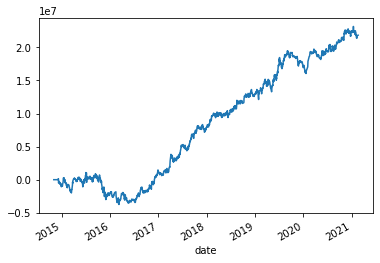

                    rb-hc-i-j_85m_18_1_3_1
avg_pnl_1y                    1.306529e+04
avg_pnl_2y                    1.728197e+04
avg_pnl_3y                    1.683321e+04
avg_pnl_4y                    2.112460e+04
avg_pnl_5y                    2.009058e+04
max_dd_period_1y             -2.600000e+01
max_dd_period_2y             -1.400000e+02
max_dd_period_3y             -1.400000e+02
max_dd_period_4y             -1.400000e+02
max_dd_period_5y             -1.400000e+02
max_drawdown_1y              -1.792284e+06
max_drawdown_2y              -3.444056e+06
max_drawdown_3y              -3.444056e+06
max_drawdown_4y              -3.444056e+06
max_drawdown_5y              -3.444056e+06
num_days_1y                   2.420000e+02
num_days_2y                   4.850000e+02
num_days_3y                   7.240000e+02
num_days_4y                   9.710000e+02
num_days_5y                   1.216000e+03
profit_dd_ratio_1y            1.764118e+00
profit_dd_ratio_2y            2.433688e+00
profit_dd_r

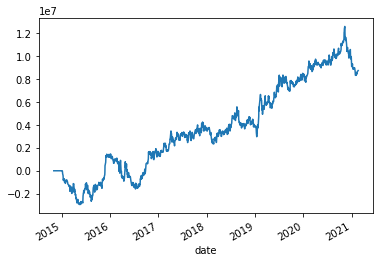

                    rb-hc-i-j-jm_s3_84_6_6_1
avg_pnl_1y                     -2.367651e+03
avg_pnl_2y                      5.039331e+03
avg_pnl_3y                      8.801681e+03
avg_pnl_4y                      6.762879e+03
avg_pnl_5y                      6.502268e+03
max_dd_period_1y               -8.400000e+01
max_dd_period_2y               -8.400000e+01
max_dd_period_3y               -8.400000e+01
max_dd_period_4y               -8.400000e+01
max_dd_period_5y               -8.400000e+01
max_drawdown_1y                -4.268728e+06
max_drawdown_2y                -4.268728e+06
max_drawdown_3y                -4.268728e+06
max_drawdown_4y                -4.268728e+06
max_drawdown_5y                -4.268728e+06
num_days_1y                     2.410000e+02
num_days_2y                     4.840000e+02
num_days_3y                     7.230000e+02
num_days_4y                     9.700000e+02
num_days_5y                     1.215000e+03
profit_dd_ratio_1y             -1.336707e-01
profit_dd_

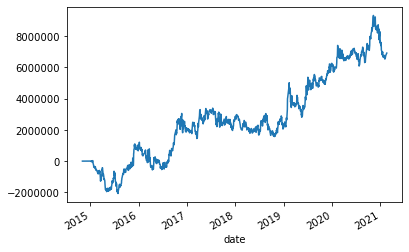

                    rb-i-j-jm_s2_36_12_3_1
avg_pnl_1y                   -1.468222e+03
avg_pnl_2y                    5.193337e+03
avg_pnl_3y                    6.757732e+03
avg_pnl_4y                    4.733559e+03
avg_pnl_5y                    5.231763e+03
max_dd_period_1y             -8.600000e+01
max_dd_period_2y             -8.600000e+01
max_dd_period_3y             -8.600000e+01
max_dd_period_4y             -8.600000e+01
max_dd_period_5y             -8.600000e+01
max_drawdown_1y              -2.781776e+06
max_drawdown_2y              -2.781776e+06
max_drawdown_3y              -2.781776e+06
max_drawdown_4y              -2.781776e+06
max_drawdown_5y              -2.781776e+06
num_days_1y                   2.410000e+02
num_days_2y                   4.840000e+02
num_days_3y                   7.230000e+02
num_days_4y                   9.700000e+02
num_days_5y                   1.215000e+03
profit_dd_ratio_1y           -1.271999e-01
profit_dd_ratio_2y            9.035864e-01
profit_dd_r

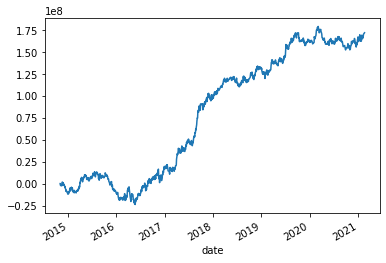

                    rb-hc-i-j_14m_30_12_3_0
avg_pnl_1y                     1.250095e+04
avg_pnl_2y                     9.637555e+04
avg_pnl_3y                     9.079592e+04
avg_pnl_4y                     1.609920e+05
avg_pnl_5y                     1.559732e+05
max_dd_period_1y              -2.070000e+02
max_dd_period_2y              -2.070000e+02
max_dd_period_3y              -2.070000e+02
max_dd_period_4y              -2.070000e+02
max_dd_period_5y              -2.070000e+02
max_drawdown_1y               -2.675367e+07
max_drawdown_2y               -2.675367e+07
max_drawdown_3y               -2.675367e+07
max_drawdown_4y               -2.675367e+07
max_drawdown_5y               -2.675367e+07
num_days_1y                    2.420000e+02
num_days_2y                    4.850000e+02
num_days_3y                    7.240000e+02
num_days_4y                    9.710000e+02
num_days_5y                    1.216000e+03
profit_dd_ratio_1y             1.130772e-01
profit_dd_ratio_2y             1

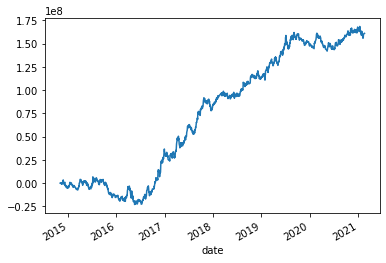

                    rb-hc-i-j_85m_18_1_3_0
avg_pnl_1y                    2.820291e+04
avg_pnl_2y                    8.292036e+04
avg_pnl_3y                    9.295370e+04
avg_pnl_4y                    1.343861e+05
avg_pnl_5y                    1.470574e+05
max_dd_period_1y             -7.700000e+01
max_dd_period_2y             -2.490000e+02
max_dd_period_3y             -2.490000e+02
max_dd_period_4y             -2.490000e+02
max_dd_period_5y             -2.490000e+02
max_drawdown_1y              -1.923809e+07
max_drawdown_2y              -1.997908e+07
max_drawdown_3y              -1.997908e+07
max_drawdown_4y              -1.997908e+07
max_drawdown_5y              -1.997908e+07
num_days_1y                   2.420000e+02
num_days_2y                   4.850000e+02
num_days_3y                   7.240000e+02
num_days_4y                   9.710000e+02
num_days_5y                   1.216000e+03
profit_dd_ratio_1y            3.547705e-01
profit_dd_ratio_2y            2.012925e+00
profit_dd_r

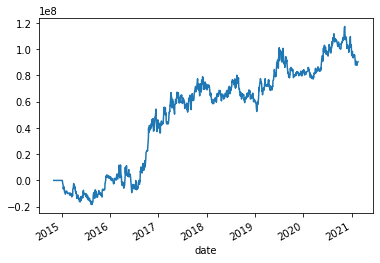

                    rb-hc-i-j-jm_s3_84_6_6_0
avg_pnl_1y                      3.506709e+04
avg_pnl_2y                      3.091512e+04
avg_pnl_3y                      4.414716e+04
avg_pnl_4y                      3.983585e+04
avg_pnl_5y                      7.422589e+04
max_dd_period_1y               -9.200000e+01
max_dd_period_2y               -9.200000e+01
max_dd_period_3y               -9.200000e+01
max_dd_period_4y               -9.200000e+01
max_dd_period_5y               -9.200000e+01
max_drawdown_1y                -2.953418e+07
max_drawdown_2y                -2.953418e+07
max_drawdown_3y                -2.953418e+07
max_drawdown_4y                -2.953418e+07
max_drawdown_5y                -2.953418e+07
num_days_1y                     2.410000e+02
num_days_2y                     4.840000e+02
num_days_3y                     7.230000e+02
num_days_4y                     9.700000e+02
num_days_5y                     1.215000e+03
profit_dd_ratio_1y              2.861488e-01
profit_dd_

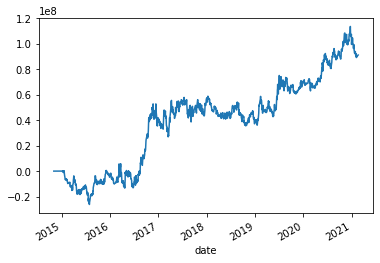

                    rb-i-j-jm_s2_36_12_3_0
avg_pnl_1y                    8.019272e+04
avg_pnl_2y                    7.753726e+04
avg_pnl_3y                    6.097442e+04
avg_pnl_4y                    4.832422e+04
avg_pnl_5y                    8.191208e+04
max_dd_period_1y             -4.600000e+01
max_dd_period_2y             -4.600000e+01
max_dd_period_3y             -4.600000e+01
max_dd_period_4y             -4.600000e+01
max_dd_period_5y             -1.140000e+02
max_drawdown_1y              -2.440640e+07
max_drawdown_2y              -2.440640e+07
max_drawdown_3y              -2.440640e+07
max_drawdown_4y              -2.440640e+07
max_drawdown_5y              -2.587873e+07
num_days_1y                   2.410000e+02
num_days_2y                   4.840000e+02
num_days_3y                   7.230000e+02
num_days_4y                   9.700000e+02
num_days_5y                   1.215000e+03
profit_dd_ratio_1y            7.918598e-01
profit_dd_ratio_2y            1.537631e+00
profit_dd_r

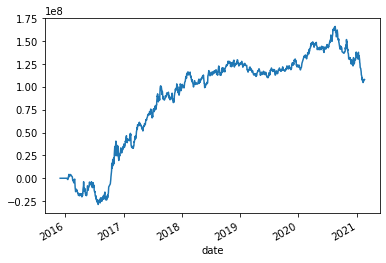

                    ZC-jm-ru-FG_s3_84_6_6_0
avg_pnl_1y                    -1.062007e+05
avg_pnl_2y                    -2.268858e+04
avg_pnl_3y                    -9.449666e+03
avg_pnl_4y                     7.403711e+04
avg_pnl_5y                     9.023169e+04
max_dd_period_1y              -1.750000e+02
max_dd_period_2y              -1.750000e+02
max_dd_period_3y              -1.750000e+02
max_dd_period_4y              -1.750000e+02
max_dd_period_5y              -1.750000e+02
max_drawdown_1y               -6.133689e+07
max_drawdown_2y               -6.133689e+07
max_drawdown_3y               -6.133689e+07
max_drawdown_4y               -6.133689e+07
max_drawdown_5y               -6.133689e+07
num_days_1y                    2.360000e+02
num_days_2y                    4.790000e+02
num_days_3y                    7.180000e+02
num_days_4y                    9.650000e+02
num_days_5y                    1.210000e+03
profit_dd_ratio_1y            -4.086182e-01
profit_dd_ratio_2y            -1

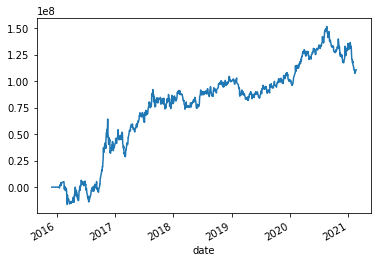

                    ZC-jm-ru-FG_s2_48_12_6_0
avg_pnl_1y                     -1.398827e+04
avg_pnl_2y                      3.551305e+04
avg_pnl_3y                      3.141998e+04
avg_pnl_4y                      7.194221e+04
avg_pnl_5y                      9.153069e+04
max_dd_period_1y               -1.760000e+02
max_dd_period_2y               -1.760000e+02
max_dd_period_3y               -1.760000e+02
max_dd_period_4y               -1.760000e+02
max_dd_period_5y               -1.760000e+02
max_drawdown_1y                -4.422779e+07
max_drawdown_2y                -4.422779e+07
max_drawdown_3y                -4.422779e+07
max_drawdown_4y                -4.422779e+07
max_drawdown_5y                -4.422779e+07
num_days_1y                     2.360000e+02
num_days_2y                     4.790000e+02
num_days_3y                     7.180000e+02
num_days_4y                     9.650000e+02
num_days_5y                     1.210000e+03
profit_dd_ratio_1y             -7.464155e-02
profit_dd_

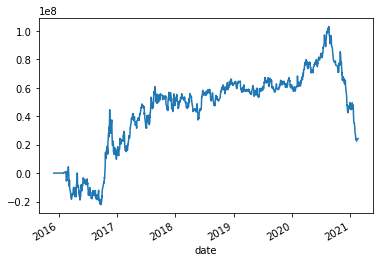

                    ZC-jm-ru-FG_s2_84_1_3_0
avg_pnl_1y                    -1.646997e+05
avg_pnl_2y                    -7.210037e+04
avg_pnl_3y                    -4.013299e+04
avg_pnl_4y                     5.182995e+03
avg_pnl_5y                     2.340484e+04
max_dd_period_1y              -1.740000e+02
max_dd_period_2y              -1.740000e+02
max_dd_period_3y              -1.740000e+02
max_dd_period_4y              -1.740000e+02
max_dd_period_5y              -1.740000e+02
max_drawdown_1y               -8.076999e+07
max_drawdown_2y               -8.076999e+07
max_drawdown_3y               -8.076999e+07
max_drawdown_4y               -8.076999e+07
max_drawdown_5y               -8.076999e+07
num_days_1y                    2.360000e+02
num_days_2y                    4.790000e+02
num_days_3y                    7.180000e+02
num_days_4y                    9.650000e+02
num_days_5y                    1.210000e+03
profit_dd_ratio_1y            -4.812323e-01
profit_dd_ratio_2y            -4

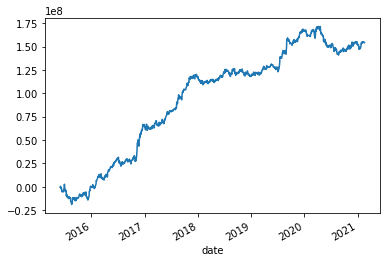

                    cu-al-zn-ni-pb-sn_43m_18_6_6_0
avg_pnl_1y                           -3.876275e+04
avg_pnl_2y                            6.660092e+04
avg_pnl_3y                            5.805617e+04
avg_pnl_4y                            9.254263e+04
avg_pnl_5y                            1.175405e+05
max_dd_period_1y                     -1.390000e+02
max_dd_period_2y                     -1.390000e+02
max_dd_period_3y                     -1.390000e+02
max_dd_period_4y                     -1.390000e+02
max_dd_period_5y                     -1.390000e+02
max_drawdown_1y                      -3.058749e+07
max_drawdown_2y                      -3.058749e+07
max_drawdown_3y                      -3.058749e+07
max_drawdown_4y                      -3.058749e+07
max_drawdown_5y                      -3.058749e+07
num_days_1y                           2.420000e+02
num_days_2y                           4.850000e+02
num_days_3y                           7.240000e+02
num_days_4y                    

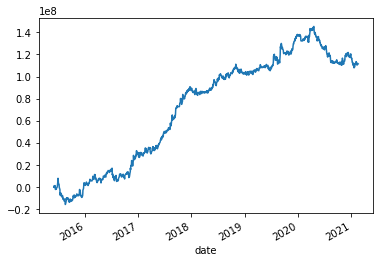

                    cu-al-zn-ni-pb-sn_43m_15_1_6_0
avg_pnl_1y                           -9.443162e+04
avg_pnl_2y                            1.457646e+04
avg_pnl_3y                            3.589364e+04
avg_pnl_4y                            7.864521e+04
avg_pnl_5y                            8.713363e+04
max_dd_period_1y                     -2.760000e+02
max_dd_period_2y                     -2.760000e+02
max_dd_period_3y                     -2.760000e+02
max_dd_period_4y                     -2.760000e+02
max_dd_period_5y                     -2.760000e+02
max_drawdown_1y                      -3.749606e+07
max_drawdown_2y                      -3.749606e+07
max_drawdown_3y                      -3.749606e+07
max_drawdown_4y                      -3.749606e+07
max_drawdown_5y                      -3.749606e+07
num_days_1y                           2.420000e+02
num_days_2y                           4.850000e+02
num_days_3y                           7.240000e+02
num_days_4y                    

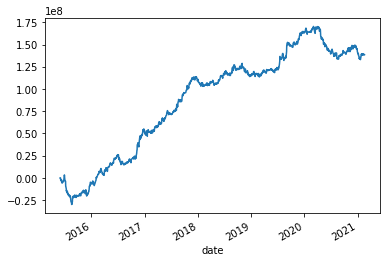

                    cu-al-zn-ni-pb-sn_43m_24_3_3_0
avg_pnl_1y                           -1.078368e+05
avg_pnl_2y                            4.464935e+04
avg_pnl_3y                            4.708355e+04
avg_pnl_4y                            8.756444e+04
avg_pnl_5y                            1.102301e+05
max_dd_period_1y                     -3.220000e+02
max_dd_period_2y                     -3.220000e+02
max_dd_period_3y                     -3.220000e+02
max_dd_period_4y                     -3.220000e+02
max_dd_period_5y                     -3.220000e+02
max_drawdown_1y                      -3.730540e+07
max_drawdown_2y                      -3.730540e+07
max_drawdown_3y                      -3.730540e+07
max_drawdown_4y                      -3.730540e+07
max_drawdown_5y                      -3.730540e+07
num_days_1y                           2.420000e+02
num_days_2y                           4.850000e+02
num_days_3y                           7.240000e+02
num_days_4y                    

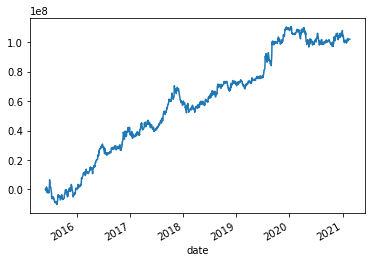

                    cu-al-zn-ni_85m_9_1_6_0
avg_pnl_1y                    -2.011405e+04
avg_pnl_2y                     6.336430e+04
avg_pnl_3y                     6.760383e+04
avg_pnl_4y                     6.605724e+04
avg_pnl_5y                     7.504027e+04
max_dd_period_1y              -3.600000e+01
max_dd_period_2y              -1.210000e+02
max_dd_period_3y              -1.210000e+02
max_dd_period_4y              -8.300000e+01
max_dd_period_5y              -8.300000e+01
max_drawdown_1y               -1.326260e+07
max_drawdown_2y               -1.403298e+07
max_drawdown_3y               -1.403298e+07
max_drawdown_4y               -1.846424e+07
max_drawdown_5y               -1.846424e+07
num_days_1y                    2.420000e+02
num_days_2y                    4.850000e+02
num_days_3y                    7.240000e+02
num_days_4y                    9.710000e+02
num_days_5y                    1.216000e+03
profit_dd_ratio_1y            -3.670170e-01
profit_dd_ratio_2y             2

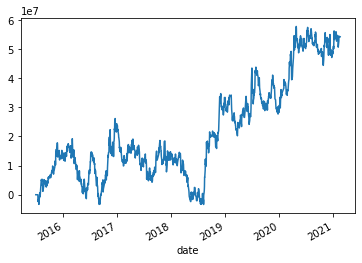

                    l-pp-v-TA-MA_s3_18_1_3_0
avg_pnl_1y                      7.058171e+04
avg_pnl_2y                      5.155625e+04
avg_pnl_3y                      5.972201e+04
avg_pnl_4y                      4.205275e+04
avg_pnl_5y                      3.199381e+04
max_dd_period_1y               -1.830000e+02
max_dd_period_2y               -1.500000e+02
max_dd_period_3y               -1.640000e+02
max_dd_period_4y               -4.780000e+02
max_dd_period_5y               -5.980000e+02
max_drawdown_1y                -1.337387e+07
max_drawdown_2y                -1.612851e+07
max_drawdown_3y                -1.792613e+07
max_drawdown_4y                -2.248353e+07
max_drawdown_5y                -2.953081e+07
num_days_1y                     2.420000e+02
num_days_2y                     4.850000e+02
num_days_3y                     7.240000e+02
num_days_4y                     9.710000e+02
num_days_5y                     1.216000e+03
profit_dd_ratio_1y              1.277175e+00
profit_dd_

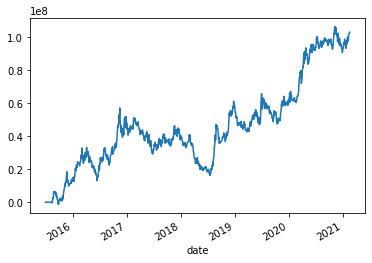

                    l-pp-v-TA-MA_s3_60_1_3_0
avg_pnl_1y                      1.748814e+05
avg_pnl_2y                      1.188600e+05
avg_pnl_3y                      9.280624e+04
avg_pnl_4y                      5.370839e+04
avg_pnl_5y                      6.651131e+04
max_dd_period_1y               -5.100000e+01
max_dd_period_2y               -1.070000e+02
max_dd_period_3y               -1.390000e+02
max_dd_period_4y               -5.110000e+02
max_dd_period_5y               -6.080000e+02
max_drawdown_1y                -1.580999e+07
max_drawdown_2y                -1.841275e+07
max_drawdown_3y                -2.447198e+07
max_drawdown_4y                -3.488804e+07
max_drawdown_5y                -4.077541e+07
num_days_1y                     2.420000e+02
num_days_2y                     4.850000e+02
num_days_3y                     7.240000e+02
num_days_4y                     9.710000e+02
num_days_5y                     1.216000e+03
profit_dd_ratio_1y              2.676870e+00
profit_dd_

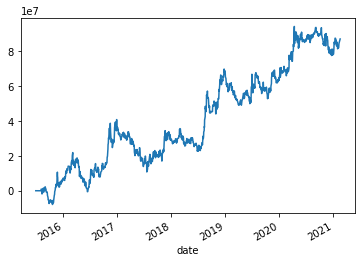

                    l-pp-v-TA-MA_s2_24_1_3_0
avg_pnl_1y                      7.511471e+04
avg_pnl_2y                      6.071891e+04
avg_pnl_3y                      7.901218e+04
avg_pnl_4y                      5.613946e+04
avg_pnl_5y                      6.228201e+04
max_dd_period_1y               -2.520000e+02
max_dd_period_2y               -2.520000e+02
max_dd_period_3y               -1.170000e+02
max_dd_period_4y               -1.260000e+02
max_dd_period_5y               -2.040000e+02
max_drawdown_1y                -1.669954e+07
max_drawdown_2y                -1.669954e+07
max_drawdown_3y                -2.077103e+07
max_drawdown_4y                -2.311090e+07
max_drawdown_5y                -3.009864e+07
num_days_1y                     2.420000e+02
num_days_2y                     4.850000e+02
num_days_3y                     7.240000e+02
num_days_4y                     9.710000e+02
num_days_5y                     1.216000e+03
profit_dd_ratio_1y              1.088519e+00
profit_dd_

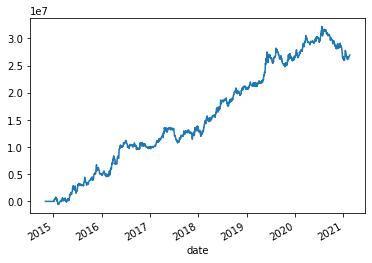

                    m-RM-y-p-OI_s4_72_3_3_1
avg_pnl_1y                    -4.074887e+03
avg_pnl_2y                     1.165734e+04
avg_pnl_3y                     1.785552e+04
avg_pnl_4y                     1.658963e+04
avg_pnl_5y                     1.841274e+04
max_dd_period_1y              -1.700000e+02
max_dd_period_2y              -1.700000e+02
max_dd_period_3y              -1.700000e+02
max_dd_period_4y              -1.700000e+02
max_dd_period_5y              -1.700000e+02
max_drawdown_1y               -6.258836e+06
max_drawdown_2y               -6.258836e+06
max_drawdown_3y               -6.258836e+06
max_drawdown_4y               -6.258836e+06
max_drawdown_5y               -6.258836e+06
num_days_1y                    2.400000e+02
num_days_2y                    4.830000e+02
num_days_3y                    7.220000e+02
num_days_4y                    9.690000e+02
num_days_5y                    1.214000e+03
profit_dd_ratio_1y            -1.562548e-01
profit_dd_ratio_2y             8

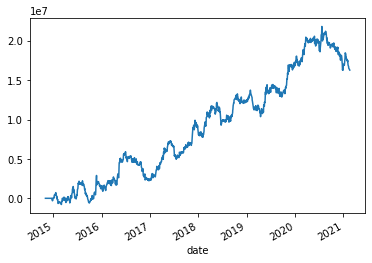

                    m-RM-y-p-OI_s4_24_12_6_1
avg_pnl_1y                     -6.032758e+03
avg_pnl_2y                      8.556840e+03
avg_pnl_3y                      1.017307e+04
avg_pnl_4y                      1.309126e+04
avg_pnl_5y                      1.187364e+04
max_dd_period_1y               -1.600000e+02
max_dd_period_2y               -1.600000e+02
max_dd_period_3y               -1.600000e+02
max_dd_period_4y               -1.600000e+02
max_dd_period_5y               -1.600000e+02
max_drawdown_1y                -5.545647e+06
max_drawdown_2y                -5.545647e+06
max_drawdown_3y                -5.545647e+06
max_drawdown_4y                -5.545647e+06
max_drawdown_5y                -5.545647e+06
num_days_1y                     2.400000e+02
num_days_2y                     4.830000e+02
num_days_3y                     7.220000e+02
num_days_4y                     9.690000e+02
num_days_5y                     1.214000e+03
profit_dd_ratio_1y             -2.610808e-01
profit_dd_

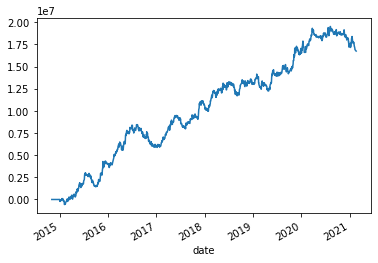

                    m-RM-y-p-OI_s2_18_1_3_1
avg_pnl_1y                    -3.283053e+03
avg_pnl_2y                     7.914581e+03
avg_pnl_3y                     7.844159e+03
avg_pnl_4y                     1.039385e+04
avg_pnl_5y                     9.739999e+03
max_dd_period_1y              -1.950000e+02
max_dd_period_2y              -1.950000e+02
max_dd_period_3y              -1.950000e+02
max_dd_period_4y              -1.950000e+02
max_dd_period_5y              -1.950000e+02
max_drawdown_1y               -2.781414e+06
max_drawdown_2y               -2.781414e+06
max_drawdown_3y               -2.781414e+06
max_drawdown_4y               -2.781414e+06
max_drawdown_5y               -2.781414e+06
num_days_1y                    2.400000e+02
num_days_2y                    4.830000e+02
num_days_3y                    7.220000e+02
num_days_4y                    9.690000e+02
num_days_5y                    1.214000e+03
profit_dd_ratio_1y            -2.832850e-01
profit_dd_ratio_2y             1

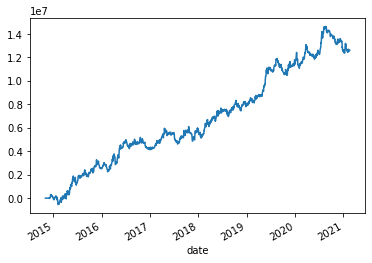

                    m-RM-y-p-OI_s1_18_1_3_1
avg_pnl_1y                     4.237038e+03
avg_pnl_2y                     9.117215e+03
avg_pnl_3y                     9.494485e+03
avg_pnl_4y                     8.164276e+03
avg_pnl_5y                     8.502717e+03
max_dd_period_1y              -1.410000e+02
max_dd_period_2y              -1.410000e+02
max_dd_period_3y              -1.410000e+02
max_dd_period_4y              -1.410000e+02
max_dd_period_5y              -1.410000e+02
max_drawdown_1y               -2.273020e+06
max_drawdown_2y               -2.273020e+06
max_drawdown_3y               -2.273020e+06
max_drawdown_4y               -2.273020e+06
max_drawdown_5y               -2.273020e+06
num_days_1y                    2.400000e+02
num_days_2y                    4.830000e+02
num_days_3y                    7.220000e+02
num_days_4y                    9.690000e+02
num_days_5y                    1.214000e+03
profit_dd_ratio_1y             4.473736e-01
profit_dd_ratio_2y             1

In [7]:
pnl_tenors = ['1y', '2y', '3y', '4y', '5y']

split_dict = {'s1': [300, 2100],
             's2': [300, 1500, 2100],
             's3': [300, 1500, 1930, 2100],
             's4': [300, 1500, 1630, 1930, 2100],}

run_list = [[['rb', 'hc', 'i', 'j'], '14m', 30, 12, 3, 1],\
            [['rb', 'hc', 'i', 'j'], '85m', 18, 1, 3, 1],\
            [['rb', 'hc', 'i', 'j', 'jm'], 's3', 84, 6, 6, 1],\
            [['rb', 'i', 'j', 'jm'], 's2', 36, 12, 3, 1],\
            [['rb', 'hc', 'i', 'j'], '14m', 30, 12, 3, 0],\
            [['rb', 'hc', 'i', 'j'], '85m', 18, 1, 3, 0],\
            [['rb', 'hc', 'i', 'j', 'jm'], 's3', 84, 6, 6, 0],\
            [['rb', 'i', 'j', 'jm'], 's2', 36, 12, 3, 0],\
            [['ZC', 'jm', 'ru', 'FG'], 's3', 84, 6, 6, 0],\
            [['ZC', 'jm', 'ru', 'FG'], 's2', 48, 12, 6, 0],\
            [['ZC', 'jm', 'ru', 'FG'], 's2', 84, 1, 3, 0], \
            [['cu', 'al', 'zn', 'ni', 'pb', 'sn'], '43m', 18, 6, 6, 0],\
            [['cu', 'al', 'zn', 'ni', 'pb', 'sn'], '43m', 15, 1, 6, 0],\
            [['cu', 'al', 'zn', 'ni', 'pb', 'sn'], '43m', 24, 3, 3, 0],\
            [['cu', 'al', 'zn', 'ni'], '85m', 9, 1, 6, 0],\
            [['l', 'pp', 'v', 'TA', 'MA'], 's3', 18, 1, 3, 0],\
            [['l', 'pp', 'v', 'TA', 'MA'], 's3', 60, 1, 3, 0],\
            [['l', 'pp', 'v', 'TA', 'MA'], 's2', 24, 1, 3, 0],\
            [['m', 'RM', 'y', 'p', 'OI'], 's4', 72, 3, 3, 1],\
            [['m', 'RM', 'y', 'p', 'OI'], 's4', 24, 12, 6, 1],\
            [['m', 'RM', 'y', 'p', 'OI'], 's2', 18, 1, 3, 1],\
            [['m', 'RM', 'y', 'p', 'OI'], 's1', 18, 1, 3, 1],\
           ]
res = {}
save_loc = "C:\\dev\\data\\cost_04_"
stats_list = []
cum_list = []
for idx, (prod_list, freq, win, ma_win, rebal, pos_std) in enumerate(run_list):
    run_args = {}
    run_args['cost_ratio'] = 0.4
    run_args['product_list'] = prod_list
    run_args['bar_freq'] = freq
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['prefix'] = save_loc
    if 's' in freq:
        run_args['std_win'] = int(freq[1:])*20
    else:
        if int(freq[:-1]) <= 30:
            run_args['std_win'] = 180
        else:
            run_args['std_win'] = 120
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    res = run_bktest(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    print(res['pnl_stats'])
    stats_list.append(res['pnl_stats'])

cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'xsmom_pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'xsmom_stats.csv')


10
                           date  min_id  (jm, open)  (jm, open)  (jm, high)  \
datetime                                                                      
2015-11-02 00:00:00  2015-11-02   600.0         NaN         NaN         NaN   
2015-11-02 00:01:00  2015-11-02   601.0         NaN         NaN         NaN   
2015-11-02 00:02:00  2015-11-02   602.0         NaN         NaN         NaN   
2015-11-02 00:03:00  2015-11-02   603.0         NaN         NaN         NaN   
2015-11-02 00:04:00  2015-11-02   604.0         NaN         NaN         NaN   
...                         ...     ...         ...         ...         ...   
2020-06-24 23:55:00  2020-06-24   555.0         NaN         NaN         NaN   
2020-06-24 23:56:00  2020-06-24   556.0         NaN         NaN         NaN   
2020-06-24 23:57:00  2020-06-24   557.0         NaN         NaN         NaN   
2020-06-24 23:58:00  2020-06-24   558.0         NaN         NaN         NaN   
2020-06-24 23:59:00  2020-06-24   559.0         N

SpecificationError: nested renamer is not supported